# 회귀실습 - 자전거 대여 수요 예측

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('./data/bike_sharing.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# Object형을 datetime형으로 변환
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
bike_df['year'] = bike_df['datetime'].apply(lambda x : x.year)
bike_df['month'] = bike_df['datetime'].apply(lambda x : x.month)
bike_df['day'] = bike_df['datetime'].apply(lambda x : x.day)
bike_df['hour'] = bike_df['datetime'].apply(lambda x : x.hour)

bike_df.drop(['datetime','casual','registered'], axis=1, inplace=True)
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


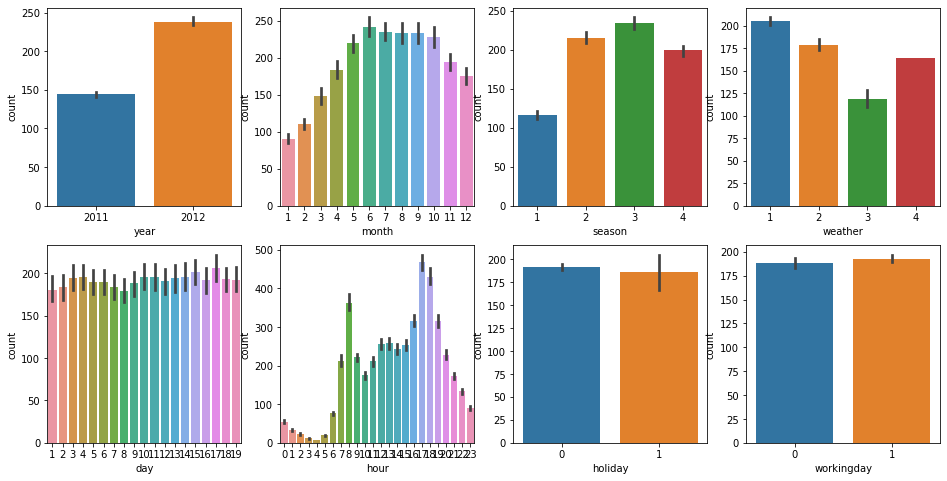

In [5]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LOG값을 활용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#MEAN_SQUARED_ERROR
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 모두계싼
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f} \nRMSE: {1:.3f} \nMAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [7]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

linear_reg = LinearRegression().fit(X_train, y_train)
pred = linear_reg.predict(X_test)
evaluate_regr(y_test,pred)

RMSLE: 1.165 
RMSE: 140.900 
MAE: 105.924


## 실제값과 예측값 차이 확인

In [8]:
def top_error_data(y_test,y_pred, n_tops=5):
    top_df = pd.DataFrame(y_test.values, columns=['real_count'])
    top_df['predict_count'] = np.round(pred)
    top_df['diff'] = np.abs(top_df['real_count']- top_df['predict_count'])
    
    print(top_df.sort_values('diff',ascending=False)[:n_tops])
top_error_data(y_test,pred,n_tops=5)

      real_count  predict_count   diff
1618         890          322.0  568.0
3151         798          241.0  557.0
966          884          327.0  557.0
412          745          194.0  551.0
2817         856          310.0  546.0


<AxesSubplot:>

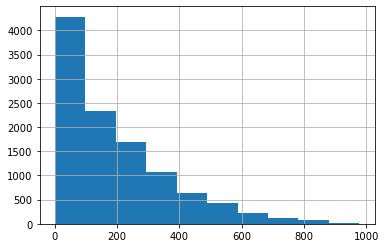

In [9]:
y_target.hist()

- count가 한쪽으로 치우쳐 많이 왜곡되어 있음

## y_target인 count 칼럼 log1p로 로그변환

In [10]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017 
RMSE: 162.594 
MAE: 109.286


<AxesSubplot:>

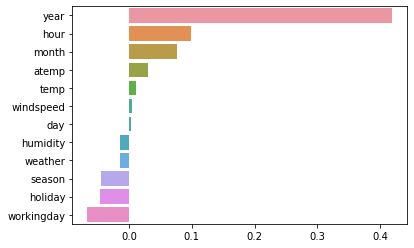

In [11]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 피처 OneHot Encoding

In [12]:
X_features_oh = pd.get_dummies(X_features, columns=['year','month','day','hour','workingday','season','weather'])
X_features_oh

,holiday,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,9.84,14.395,81,0.0000,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,0,9.02,13.635,80,0.0000,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,9.02,13.635,80,0.0000,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,0,9.84,14.395,75,0.0000,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0,9.84,14.395,75,0.0000,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,15.58,19.695,50,26.0027,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,0,14.76,17.425,57,15.0013,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,0,13.94,15.910,61,15.0013,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,0,13.94,17.425,61,6.0032,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_features_oh, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test,pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=False)

LinearRegression
RMSLE: 0.142 
RMSE: 0.590 
MAE: 0.441
Ridge
RMSLE: 0.142 
RMSE: 0.590 
MAE: 0.443
Lasso
RMSLE: 0.153 
RMSE: 0.635 
MAE: 0.490


<AxesSubplot:>

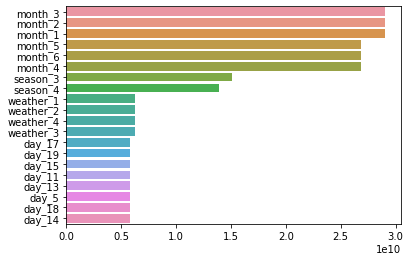

In [18]:
coef = pd.Series(lr_reg.coef_,index=X_features_oh.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=False)

RandomForestRegressor
RMSLE: 0.094 
RMSE: 0.354 
MAE: 0.243
GradientBoostingRegressor
RMSLE: 0.088 
RMSE: 0.330 
MAE: 0.236
XGBRegressor
RMSLE: 0.093 
RMSE: 0.342 
MAE: 0.238
LGBMRegressor
RMSLE: 0.086 
RMSE: 0.319 
MAE: 0.222
